# Herzfehler Prognose
## Binäre Klassifikation
### Daten Laden


In [78]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [79]:
df = pd.read_csv("../Heart Failure/data/heart.csv")

### Datenqualität

In [80]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [81]:
df.shape

(918, 12)

In [82]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [84]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [85]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Daten grobe Formatierung

In [86]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [87]:
df.columns = ["Alter", "Geschlecht", "Typ_Burstschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAgina", "Oldpeak", "ST_Steigung", "Herzversagen"]

### Daten verstehen

In [88]:
df.head()

,Alter,Geschlecht,Typ_Burstschmerz,Ruhender_Blutdruck,Cholesterin,Nüchterner_Blutzucker,Ruhe-EKG,Max_Herzrate,ExcerciseAgina,Oldpeak,ST_Steigung,Herzversagen
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [128]:
selected_columns = df.columns[:-1]

# Sortieren Sie den DataFrame, sodass die Werte mit Herzkrankheit = 1 zuerst kommen
df = df.sort_values(by='Herzversagen', ascending=False)

color_map = {0: 'red', 1: 'blue'}  # Rot für 0, Blau für 1

for attribut in selected_columns:
    fig = px.histogram(df, x=attribut, title=f"Histogramm von {attribut}", 
                       color='Herzversagen', opacity=0.8, barmode='overlay',
                       color_discrete_map=color_map)  # Definiere die Farben
    fig.show()


In [90]:
#Anzahl von Kranken und Gesunden
grouped_krankheiten = df.groupby(by="Herzversagen")
grouped_krankheiten["Herzversagen"].count()

Herzversagen
0    410
1    508
Name: Herzversagen, dtype: int64

<Axes: >

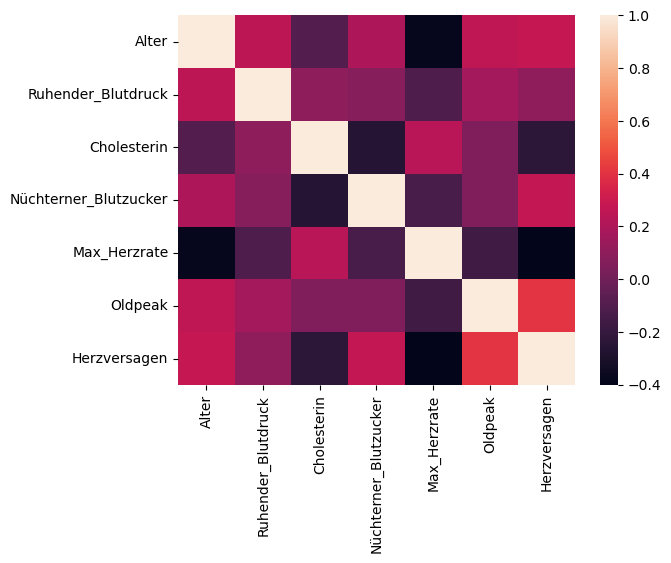

In [91]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False)

### Daten für Modelling formatieren

In [92]:
#Libs
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [93]:
#Zielvariable definieren
X = df.drop("Herzversagen", axis=1)
y = df["Herzversagen"]

In [94]:
X.head()

,Alter,Geschlecht,Typ_Burstschmerz,Ruhender_Blutdruck,Cholesterin,Nüchterner_Blutzucker,Ruhe-EKG,Max_Herzrate,ExcerciseAgina,Oldpeak,ST_Steigung
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [95]:
kategorische_spalten = ["Geschlecht", "Typ_Burstschmerz", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAgina", "Oldpeak", "ST_Steigung"]
# Wandle kategorische Daten um
label_encoders = {}
for col in kategorische_spalten:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])
    label_encoders[col] = encoder  # Speichere den Encoder, falls du ihn später benötigst


In [96]:
# Normalisierung der Daten
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [97]:
# Aufteilung in Trainings- und Testdaten
X_train_scal, X_test_scal, y_train_scal, y_test_scal = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [98]:
# Ausgabe der Dimensionen der Trainings- und Testdaten
print("Trainingsdaten Größe:", X_train_scal.shape)
print("Testdaten Größe:", X_train_scal.shape)

Trainingsdaten Größe: (734, 11)
Testdaten Größe: (734, 11)


### Logistische Regression

In [99]:
#Bibliotheken
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [101]:
# Erstellen und Trainieren des logistischen Regressionsmodells
model_lgr = LogisticRegression()
model_lgr.fit(X_train_scal, y_train_scal)

LogisticRegression()

In [102]:
# Vorhersagen auf Testdaten
y_pred_log = model_lgr.predict(X_test_scal)

In [103]:
conf_matrix_lg = confusion_matrix(y_test_scal, y_pred_log)
print("Konfusionsmatrix:\n", conf_matrix_lg)

Konfusionsmatrix:
 [[68  9]
 [20 87]]


In [104]:
import seaborn as sns

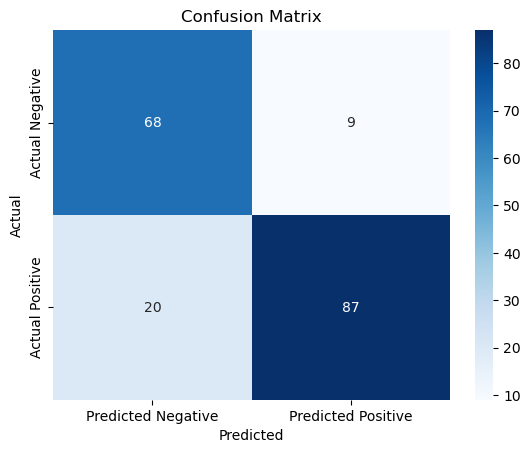

In [105]:
# Erstellung einer Heatmap zur visuellen Darstellung der Konfusionsmatrix
sns.heatmap(conf_matrix_lg, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# Bewertung des Modells
accuracy = accuracy_score(y_test_scal, y_pred_log)
print("Genauigkeit:", accuracy)

Genauigkeit: 0.842391304347826


In [107]:
class_report = classification_report(y_test_scal, y_pred_log)
print("Klassifikationsbericht:\n", class_report)

Klassifikationsbericht:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82        77
           1       0.91      0.81      0.86       107

    accuracy                           0.84       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.84      0.84       184



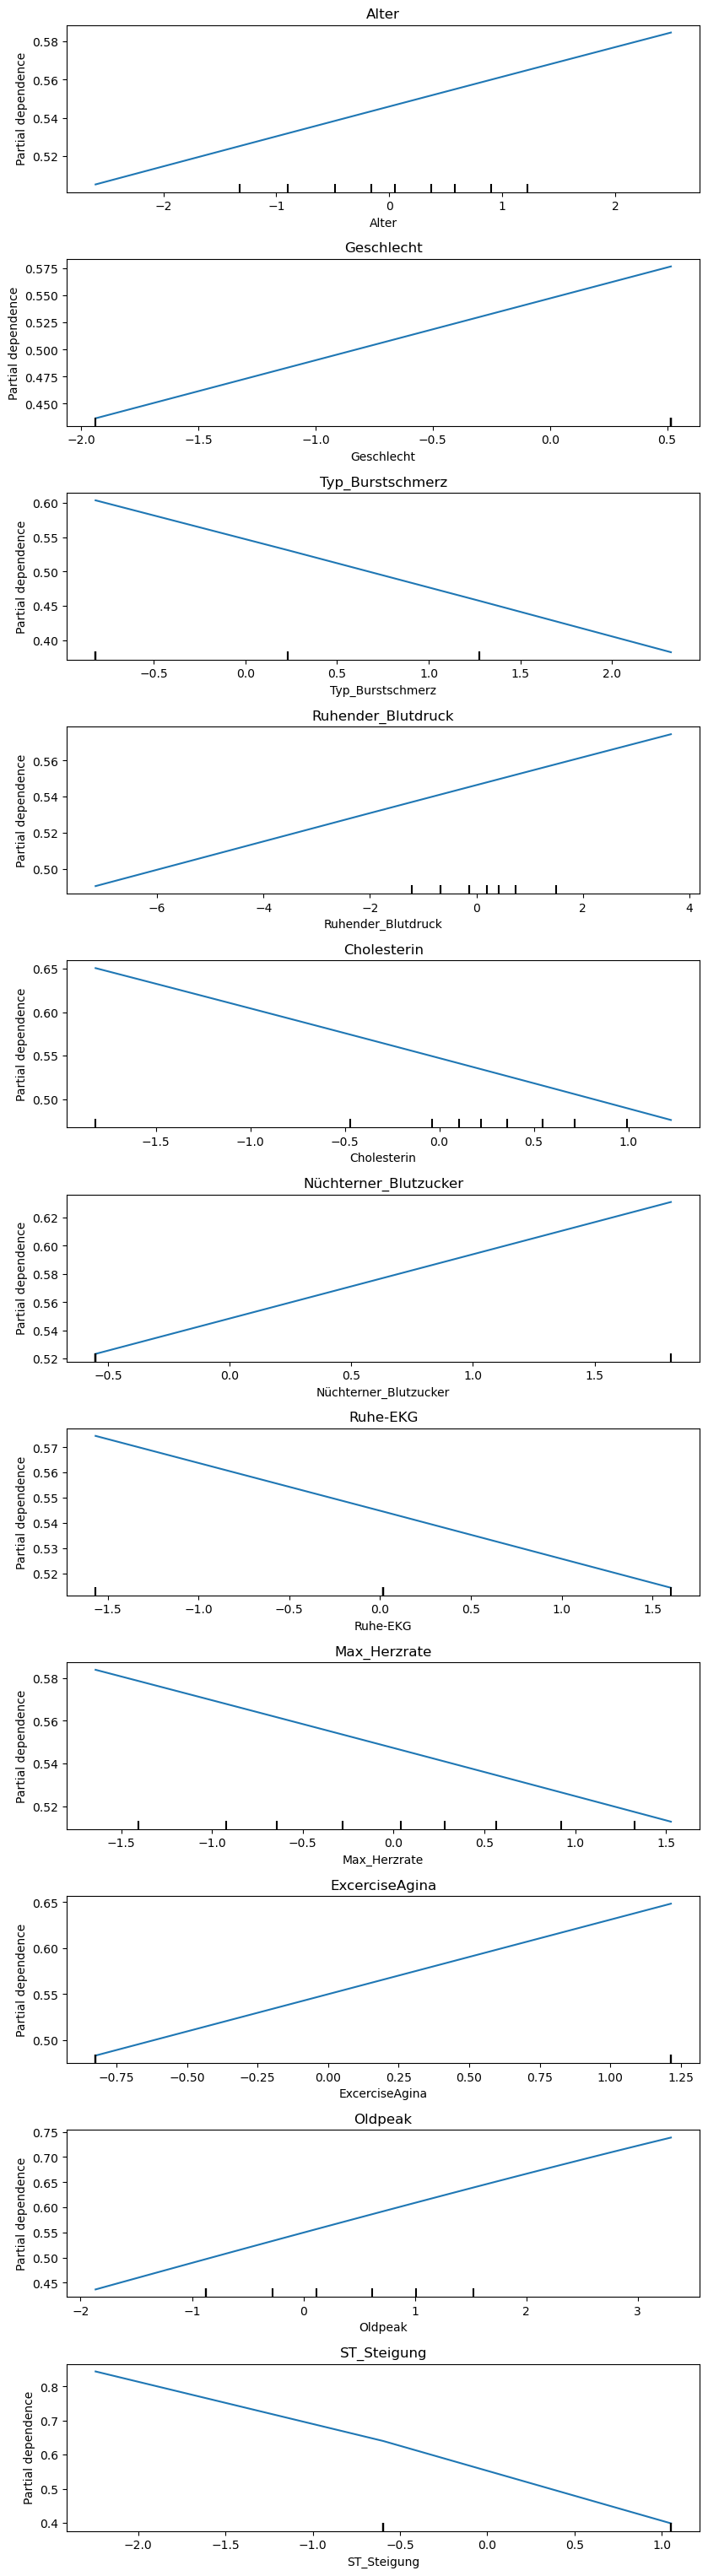

In [108]:
# Ihre Feature-Namen
feature_names = ['Alter', 'Geschlecht', 'Typ_Burstschmerz', 'Ruhender_Blutdruck',
       'Cholesterin', 'Nüchterner_Blutzucker', 'Ruhe-EKG', 'Max_Herzrate',
       'ExcerciseAgina', 'Oldpeak', 'ST_Steigung']

# Plot der Partial Dependence Plots
fig_width = 10  # Breite des Plots
fig_height_per_subplot = 3  # Höhe pro Subplot
fig, ax = plt.subplots(len(feature_names), 1, figsize=(fig_width, fig_height_per_subplot * len(feature_names)))

# Erzeugen der Partial Dependence Plots
for i, feature in enumerate(feature_names):
    disp = PartialDependenceDisplay.from_estimator(model_lgr, X_train_scal, features=[i],
                                                   feature_names=feature_names, ax=ax[i])
    ax[i].set_ylabel('')  # Entfernen der y-Achsen-Beschriftung
    ax[i].set_title(feature)  # Setzen des Feature-Namens als Titel

# Anpassung des Layouts
fig.subplots_adjust(top=0.95, bottom=0.05, left=0.2, right=0.95, hspace=0.4, wspace=0.2)

plt.show()

### Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
X.head()

,Alter,Geschlecht,Typ_Burstschmerz,Ruhender_Blutdruck,Cholesterin,Nüchterner_Blutzucker,Ruhe-EKG,Max_Herzrate,ExcerciseAgina,Oldpeak,ST_Steigung
0,40,1,1,140,289,0,1,98,0,10,2
1,49,0,2,160,180,0,1,82,0,20,1
2,37,1,1,130,283,0,2,25,0,10,2
3,48,0,0,138,214,0,1,34,1,25,1
4,54,1,2,150,195,0,1,48,0,10,2


In [111]:
# Aufteilung in Trainings- und Testdaten
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
model_rf = RandomForestClassifier(max_depth=3, random_state=10)

In [113]:
model_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=3, random_state=10)

In [114]:
y_pred_rf = model_rf.predict(X_test_rf)

In [115]:
accuracy_score(y_test_rf,y_pred_rf)

0.8695652173913043

In [116]:
confusion_matrix(y_test_rf, y_pred_rf)

array([[67, 10],
       [14, 93]])

In [117]:
conf_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)
print("Konfusionsmatrix:\n", conf_matrix_lg)

Konfusionsmatrix:
 [[68  9]
 [20 87]]


In [118]:
class_report = classification_report(y_test_rf, y_pred_rf)
print("Klassifikationsbericht:\n", class_report)

Klassifikationsbericht:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85        77
           1       0.90      0.87      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



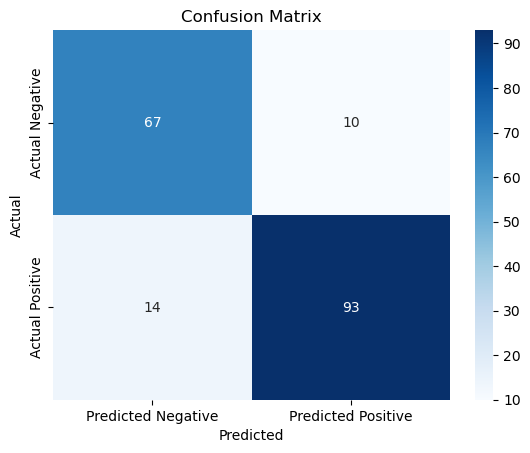

In [119]:
# Erstellung einer Heatmap zur visuellen Darstellung der Konfusionsmatrix
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# PD

In [170]:
from sklearn.inspection import partial_dependence


In [171]:
alter_index = feature_names.index("Alter")
pdp_results = partial_dependence(model_rf, X_train_rf, features=[alter_index])


In [173]:
pdp_alter_values = pdp_results['average'][0]  # Die durchschnittliche Abhängigkeit
pdp_alter_axis = pdp_results['values'][0]     # Die Werte für das Feature "Alter"

In [177]:

# Erstellen eines DataFrames zur Darstellung der Partial Dependence Daten
pdp_df = pd.DataFrame({
    'Alter': pdp_alter_axis,
    'Durchschnittliche Abhängigkeit': pdp_alter_values
})

# Anzeigen der Tabelle
print(pdp_df)

    Alter  Durchschnittliche Abhängigkeit
0      29                        0.528443
1      31                        0.528443
2      32                        0.528443
3      33                        0.528443
4      34                        0.528443
5      35                        0.528443
6      36                        0.528443
7      37                        0.528443
8      38                        0.528443
9      39                        0.528443
10     40                        0.528443
11     41                        0.528443
12     42                        0.527765
13     43                        0.527765
14     44                        0.527765
15     45                        0.527765
16     46                        0.530067
17     47                        0.531631
18     48                        0.533241
19     49                        0.533241
20     50                        0.533241
21     51                        0.533241
22     52                        0

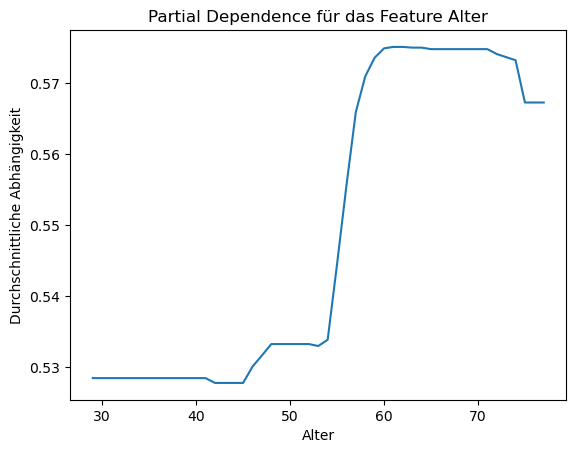

In [172]:
pdp_alter_values = pdp_results['average'][0]  # Die durchschnittliche Abhängigkeit
pdp_alter_axis = pdp_results['values'][0]     # Die Werte für das Feature "Alter"

# Plotting
plt.plot(pdp_alter_axis, pdp_alter_values)
plt.xlabel('Alter')
plt.ylabel('Durchschnittliche Abhängigkeit')
plt.title('Partial Dependence für das Feature Alter')
plt.show()


# PDP

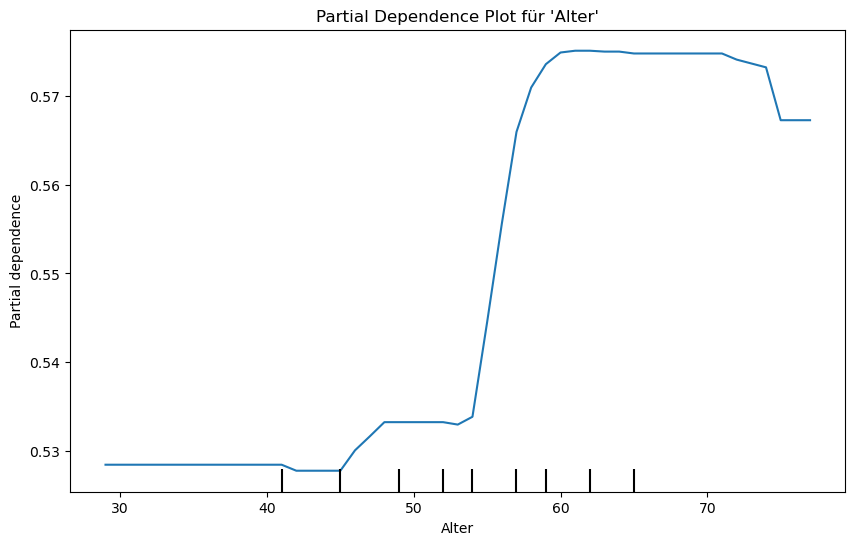

In [169]:

# Ihre Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Brustschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAngina", "Oldpeak", "ST_Steigung"]

# Indizes des Features "Alter" in der Liste der Feature-Namen
feature_index = feature_names.index("Alter")

# Erstellung des Partial Dependence Plots für das Feature "Alter"
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[feature_index],
    feature_names=feature_names, ax=ax)

ax.set_title("Partial Dependence Plot für 'Alter'")
plt.show()


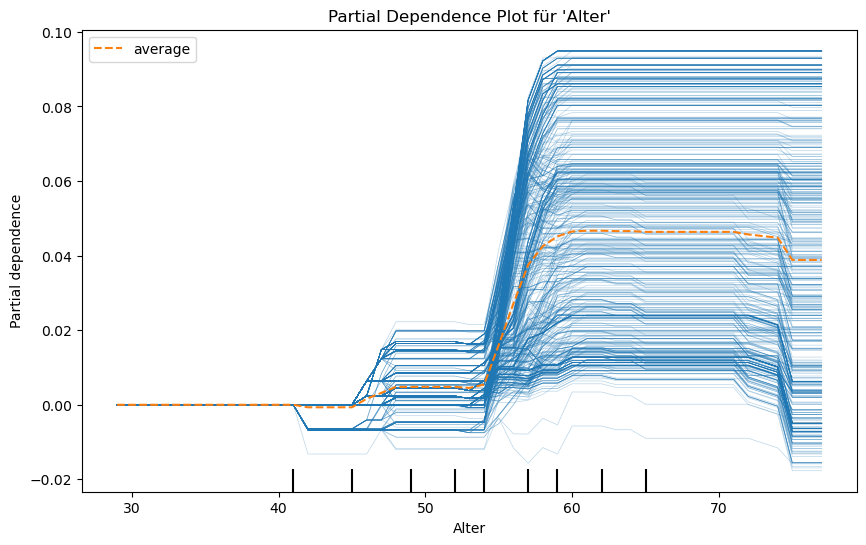

In [162]:

# Ihre Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Brustschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAngina", "Oldpeak", "ST_Steigung"]

# Indizes des Features "Alter" in der Liste der Feature-Namen
feature_index = feature_names.index("Alter")

# Erstellung des Partial Dependence Plots für das Feature "Alter"
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[feature_index],
    feature_names=feature_names, ax=ax,
    kind='both', centered=True)

ax.set_title("Partial Dependence Plot für 'Alter'")
plt.show()


In [154]:
# PQRST
print(df["ST_Steigung"].unique())
print(X_train_rf["ST_Steigung"].unique())

['Down' 'Flat' 'Up']
[0 2 1]


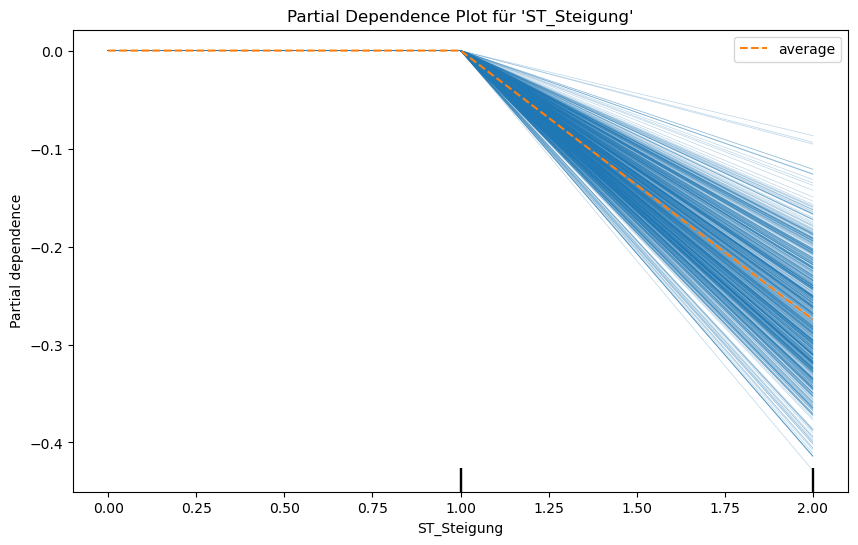

In [163]:

# Ihre Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Brustschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAngina", "Oldpeak", "ST_Steigung"]

# Indizes des Features "Alter" in der Liste der Feature-Namen
feature_index = feature_names.index("ST_Steigung")

# Erstellung des Partial Dependence Plots für das Feature "Alter"
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[feature_index],
    feature_names=feature_names, ax=ax, kind='both', centered=True)

ax.set_title("Partial Dependence Plot für 'ST_Steigung'")
plt.show()

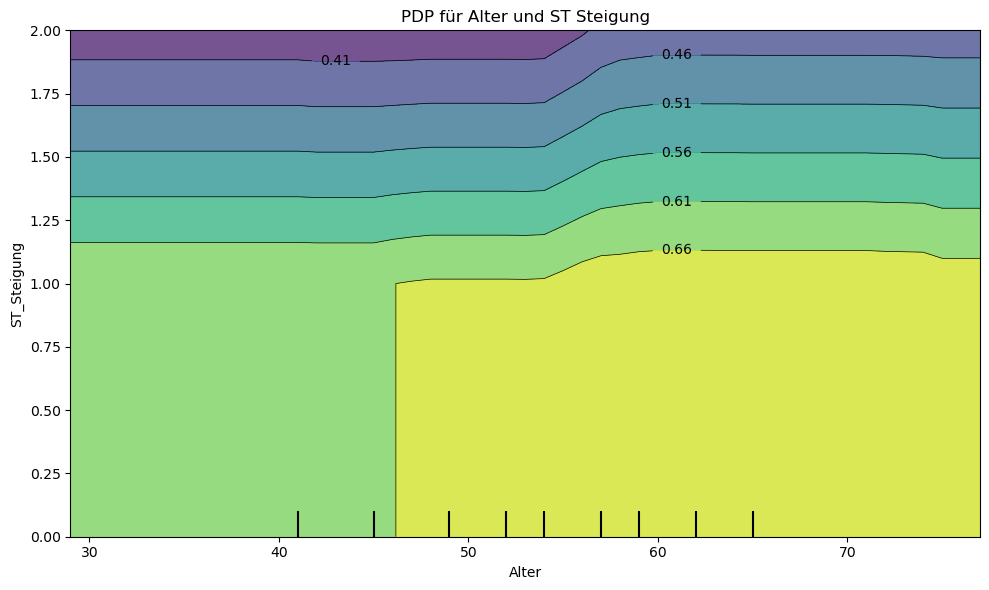

In [168]:
# AQ X_train_rfXXXF aqW^ Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Brustschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAngina", "Oldpeak", "ST_Steigung"]

# Indizes der Features
alter_index = feature_names.index("Alter")
ST_Steigung_index = feature_names.index("ST_Steigung")


# Erstellung der Partial Dependence Plots
fig, axo = plt.subplots(figsize=(10, 6))  # Nur eine Achse


#PDP für Alter und Cholesterin
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[(alter_index, ST_Steigung_index)],
    feature_names=feature_names, ax=axo)
axo.set_title("PDP für Alter und ST Steigung")


plt.tight_layout()
plt.show()




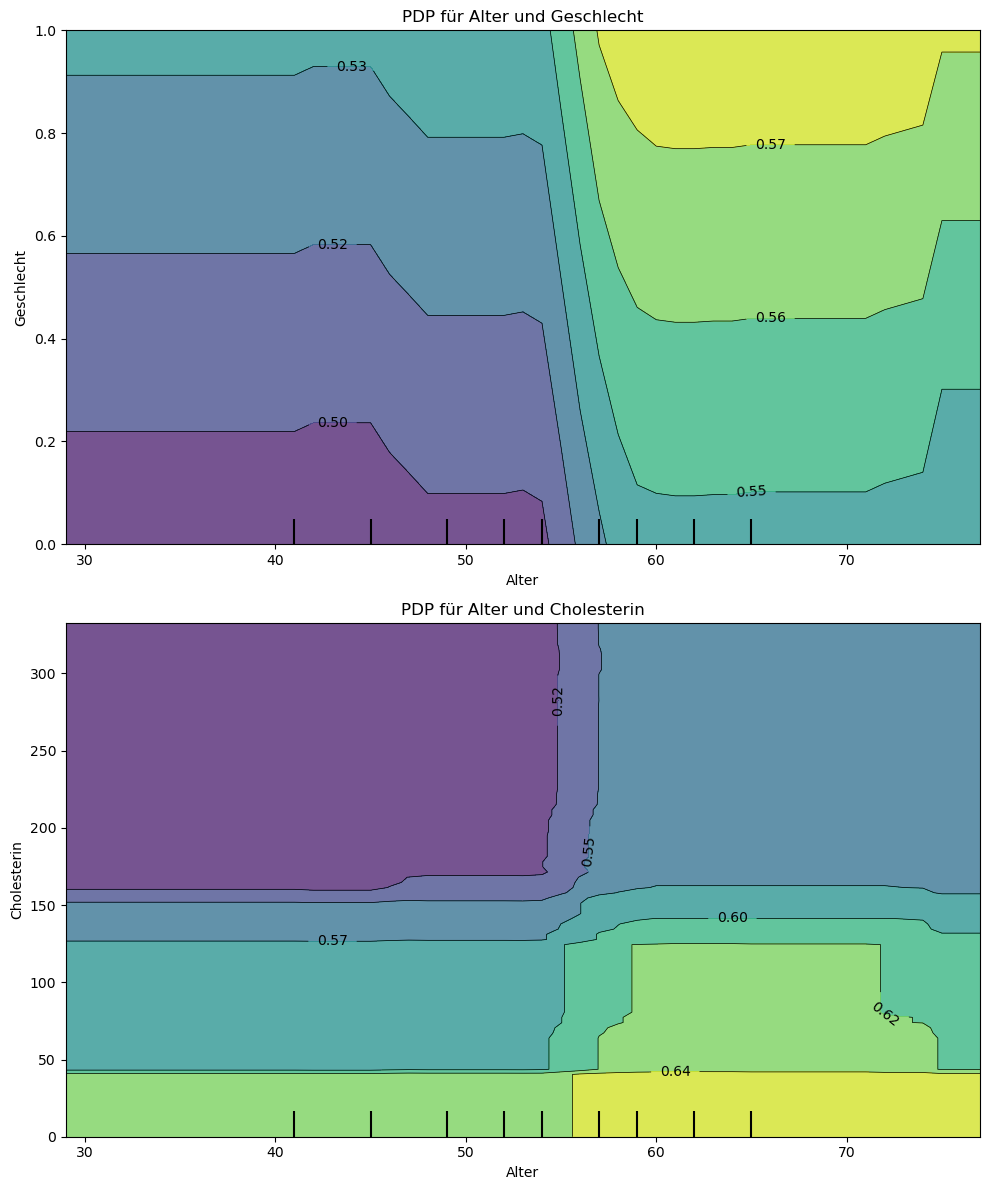

In [158]:
#  Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Brustschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAngina", "Oldpeak", "ST_Steigung"]

# Indizes der Features
alter_index = feature_names.index("Alter")
geschlecht_index = feature_names.index("Geschlecht")
cholesterin_index = feature_names.index("Cholesterin")
# Erstellung der Partial Dependence Plots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

#  PDP für Alter und Geschlecht
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[(alter_index, geschlecht_index)],
    feature_names=feature_names, ax=axs[0])
axs[0].set_title("PDP für Alter und Geschlecht")

# PDP für Alter und Cholesterin
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[(alter_index, cholesterin_index)],
    feature_names=feature_names, ax=axs[1])
axs[1].set_title("PDP für Alter und Cholesterin")


plt.tight_layout()
plt.show()


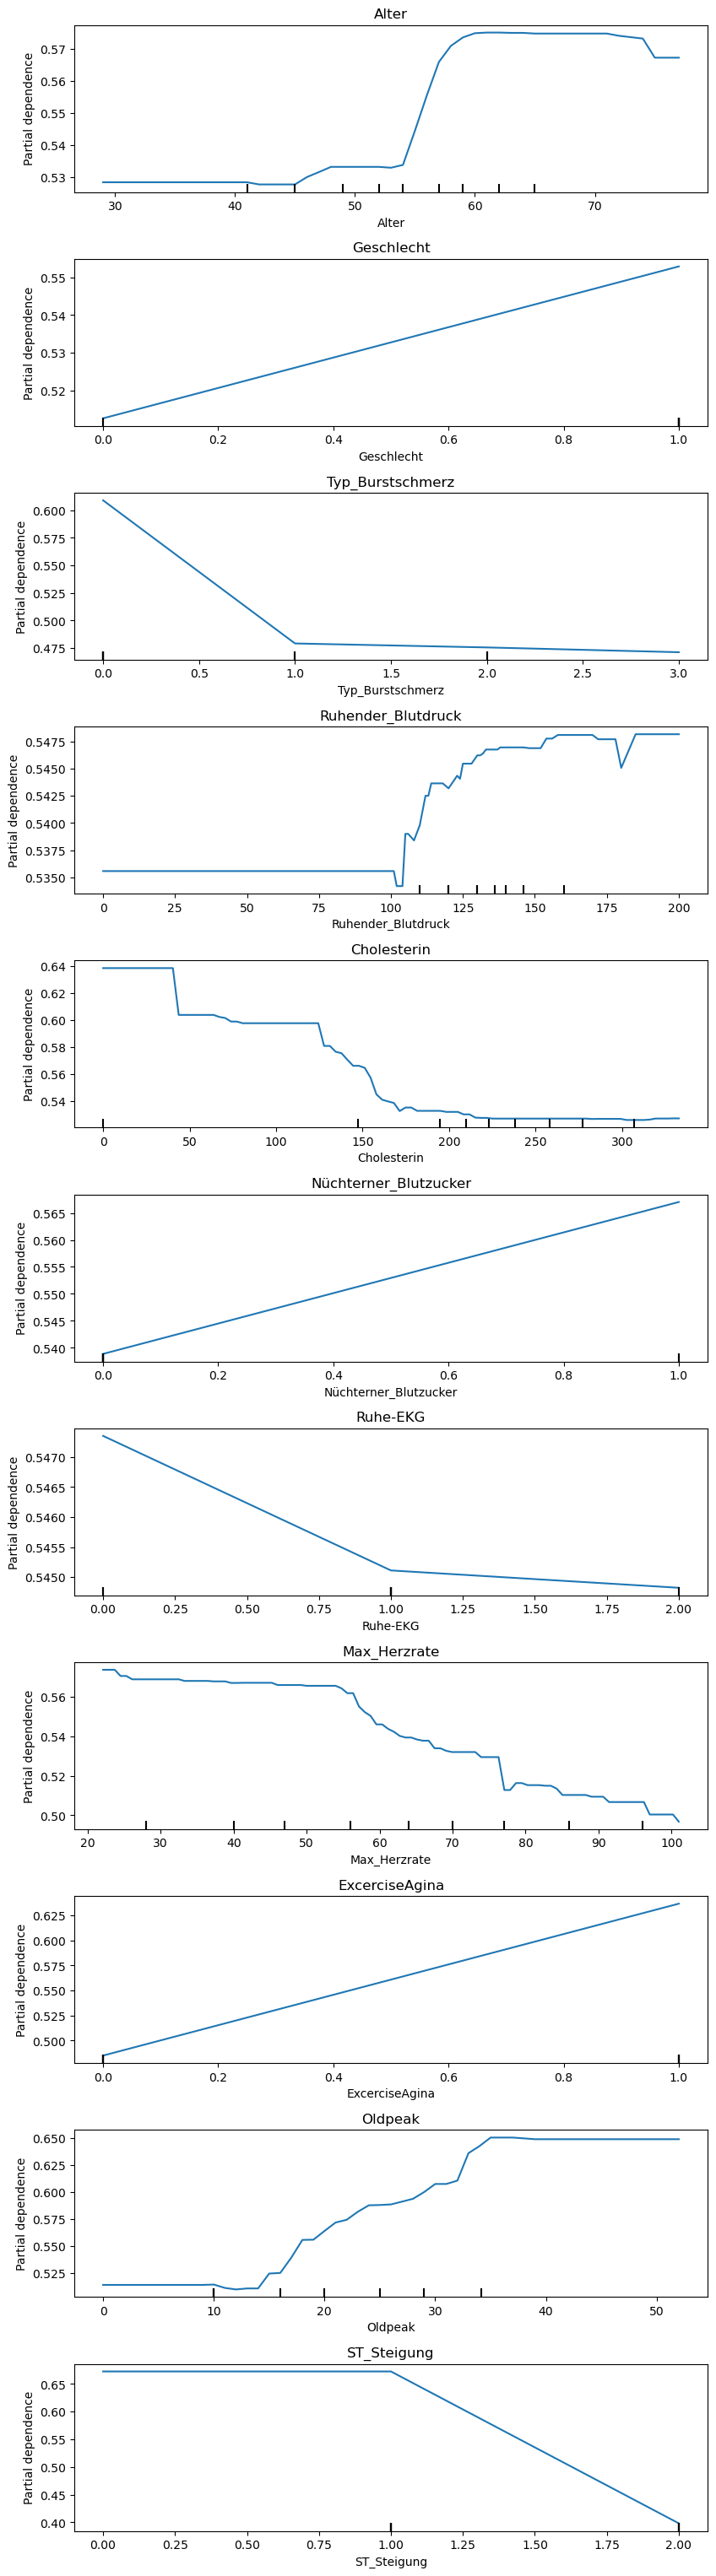

i: 10   feature:ST_Steigung


In [120]:
# Ihre Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Burstschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAgina", "Oldpeak", "ST_Steigung"]
# Plot der Partial Dependence Plots
fig_width = 10  # Breite des Plots
fig_height_per_subplot = 3  # Höhe pro Subplot
fig, ax = plt.subplots(len(feature_names), 1, figsize=(fig_width, fig_height_per_subplot * len(feature_names)))

# Erzeugen der Partial Dependence Plots
for i, feature in enumerate(feature_names):
    disp = PartialDependenceDisplay.from_estimator(model_rf, X_train_rf, features=[i],
                                                   feature_names=feature_names, ax=ax[i])
    ax[i].set_ylabel('')  # Entfernen der y-Achsen-Beschriftung
    ax[i].set_title(feature)  # Setzen des Feature-Namens als Titel

# Anpassung des Layouts
fig.subplots_adjust(top=0.95, bottom=0.05, left=0.2, right=0.95, hspace=0.4, wspace=0.2)

plt.show()
print(f'i: {i}   feature:{feature}')